# Práctica Sympy 2

Generar un modelo de simulacion para el proceso de vacunacion del Covid. Para ello se debe investigar algun recinto de vacunacion con el objetivo de generar metricas en base a los siguientes datos:

    * Personal de vacunacion 
    * Numero de personas llamadas
    * Otros parametros

El proceso de vacunacion es el siguiente:
    * La persona llega 20 minutos antes de la hora de la vacuna
    * Ingresa a la cola/fila a que le toque su turno
    * Tenemos un proceso de control en donde se toma los signos vitales y se valida que este dentro del padron (2-5 minutos)
    * Como ejemplificacion menos del 5% no es vacunada ya que presenta signos de alerta.
    * Se procede al traslado a la cama/silla de vacunacion y se inyecta la dosis de la vacuna, este proceso tarda entre (5-10 minutos)
    * Finalmente son llevadas a la salida
    
Finalmente generar las siguientes metricas/graficas:
    * Tiempo de espera promedio de cada persona
    * Tiempo promedio total que requiere un paciente para ser vacunado
    * Cuantos pacientes se atendieron
    * Cuantos pacientes se quedaron sin atender

## Definimos nuestras variables globales

In [79]:
import simpy
import random
import matplotlib.pyplot as pp
import math

# Numero de personas que se encargan de la vacunacion (5-6)
NUM_PERSONAL = 6

# Numero de personas llamadas a la vacunacion (40-50)
NUM_PERSONAS = 50

# Tiempo proceso de control (2-5 minutos)
PROCESO_CONTROL = 4

# Representa el numero de personas que no seran vacunadas
# Solo el 5% no pasa el control y no se vacuna
# Para ello obtenemos el numero de personas que representa el 5% 
NO_VACUNADAS = (NUM_PERSONAS * 5)/100

# Tiempo traslado persona hacia silla o camilla (5-10 minutos)
TRASLADO_CAMILLA = 6

# Tiempo que se demora en vacunar (3 a 5 minutos)
TIEMPO_VACUNACION = 5

# Tiempo de simulación
TIEMPO_SIMULACION = 100

# Intervalo de tiempo en que llegan las personas (minutos)
INTERVALO_LLEGADA = 5

# Creamos un diccionario para almacenar la persona y el tiempo de espera antes de pasar al control
tiempo_espera = {}

# Creamos un diccionario para almacenar la persona y el tiempo total que toma vacunarse
tiempo_total_vacunacion = {}

# Creamos un diccionario para almacenar las persona vacunadas
vacunados = {}

# Creamos un diccionario para almacenar las personas no vacunadas
no_vacunados = {}

# Creamos un diccionario para almacenar las personas y sus estados
# ya sean: en espera, en control, en traslado y vacunada.
personas = {}

## Creamos nuestra clase vacunacion la cual tendra las funciones de vacunar, de proceso de control y de trasladar.

In [80]:
class Vacunacion(object):
    
    def __init__(self, environment, num_personal, tiempo_vacunacion, traslado_camilla):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.personal = simpy.Resource(environment, num_personal)
        # Variable para el tiempo de lavado
        self.tiempo_vacunacion = tiempo_vacunacion
        self.traslado_camilla = traslado_camilla
        
    def vacunar_persona(self, persona):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION-1, TIEMPO_VACUNACION+1))
        # Guardamos a la persona con estado "Vacunada"
        personas[persona] = "Vacunada"
        # Si se ha vacunado guardamos a la persona con su tiempo
        tiempo_total_vacunacion[persona] = env.now
        
    def trasladar_persona(self, persona):
        yield self.env.timeout(TRASLADO_CAMILLA)
        # Guardamos a la persona con estado "Traslado"
        personas[persona] = "Traslado"
        
        
    def proceso_control(self, persona):
        yield self.env.timeout(PROCESO_CONTROL)
        # Guardamos a la persona con estado "Control"
        personas[persona] = "Control"
        # Guardamos a la persona con el tiempo
        # Esto no permite saber cuando tuvo que esperar una persona para ser atendida
        tiempo_espera[persona] = env.now
       
    
def llegada_persona(env, nombre, vacunacion):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega la con el nombre pasado como parametro
    print('Llega %s a la hora %.2f.' % (nombre, env.now))
    # Ponemos como estado "Espera" a la persona
    personas[nombre] = "Espera"
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la estacion de vacunacion
    with vacunacion.personal.request() as personal:
        # Ocupamos el area del personal
        yield personal
        # Entra al proceso de control
        yield env.process(vacunacion.proceso_control(nombre))
        
        # Verificamos que el numero de personas no vacunadas
        # no exceda al 5% de personas que no son vacunadas 
        # segun el numero de personas que asisten a vacunarse
        if(len(no_vacunados.keys())<=(int(math.floor(NO_VACUNADAS)))):  
            
            # Generamos un numero randomico entre 1 y 20 que representa el 5%
            # y que sea menor o igual a 5. 
            # Realizamos esto para darle mas aleatoriedad al modelo
            if((random.randint(1,20))<=5):
                # Si se cumplen las condiciones (no pasa el control) lo guardamos en no vacunados
                no_vacunados[nombre]=env.now
                print('** [%s] no ha pasado el control**' % (nombre))
                print('** [%s] no ha sido vacunada**' % (nombre)) 
            else:
                # Si pasa el control se procede a su traslado 
                print('[%s] a pasado el control' % (nombre)) 
                #Indicamos que la persona se esta trasladando para ser vacunada
                print('Se traslada %s a la hora %.2f.' % (nombre,env.now))
                #Procesamos el traslado de la persona
                yield env.process(vacunacion.trasladar_persona(nombre))
                # Indicamos que la persona entra a vacunarse
                print('Entra %s a vacunarse a la hora %.2f.' % (nombre, env.now))
                # Procesamos la operacion de vacunacion
                yield env.process(vacunacion.vacunar_persona(nombre))
                # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
                print('[%s] vacunada a las %.2f.' % (nombre, env.now))  
                # Guardamos el nombre de la persona vacunada y el tiempo en que le tomo vacunarse
                vacunados[nombre]=env.now
   
                
        
def ejecutar_simulacion(env, num_personal, tiempo_vacunacion, traslado_camilla, intervalo):
    vacunacion=Vacunacion(env, num_personal, tiempo_vacunacion, traslado_camilla)
    # Creamos 5 llegadas de personas iniciales
    for i in range(5):
        env.process(llegada_persona(env, 'Persona-%d'%(i+1),vacunacion))
        
    # Ejecutamos la simulacion
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2))
        i+=1
        # Mientras se vacunan las personas llegan mas
        env.process(llegada_persona(env,'Persona-%d'%(i+1),vacunacion))

## Ejecutamos la simulacion y calculamos el numero de personas atendidas, el numero de personas no atendidas, el numero de personas vacunadas y el numero de personas no vacunadas. Asi como tambien los tiempo de espera y de vacunacion. Luego mostramos las metricas.

In [81]:
print('Centro de Vacunacion')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_PERSONAL, TIEMPO_VACUNACION, TRASLADO_CAMILLA, INTERVALO_LLEGADA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

# Recorremos nuestro diccionario personas, en donde tenemos guardada
# a la persona con su estado, de manera que solo contamos las personas
# con estado igual a espera, esto nos permite obtener el numero de personas
# que no fueron atendidas y solo se quedaron en espera.
# de igual manera si su estado es diferente a espera, se considera que la 
# persona fue atendida y se cuenta.
personas_no_atendidas=0
personas_atendidas=0
for persona in personas:
    if(personas[persona]=="Espera"):
        personas_no_atendidas+=1
    else:
        personas_atendidas+=1
        

# Recorremos nuestro diccionario tiempo_espera, en donde tenemos guardada
# a la persona con su tiempo, antes de pasar al proceso control
# de manera que solo accedemos al tiempo de cada persona y lo sumamos
# por ultimo dividimos la suma de todos los tiempos de espera
# para el numero de personas que se quedaron en espera
promedio_espera=0
for tiempo in tiempo_espera:
    promedio_espera=promedio_espera+tiempo_espera[tiempo]
promedio_espera=promedio_espera/len(tiempo_espera.keys())


# Recorremos nuestro diccionario tiempo_total_vacunacion, en donde 
# tenemos guardada a la persona ya vacunada con su tiempo 
# de manera que solo accedemos al tiempo de cada persona y lo sumamos
# por ultimo dividimos la suma de todos los tiempos
# para el numero de personas que fueron vacunadas
promedio_vacunacion=0
for tiempo in tiempo_total_vacunacion:
    promedio_vacunacion=promedio_vacunacion+tiempo_total_vacunacion[tiempo]
promedio_vacunacion=promedio_vacunacion/len(tiempo_total_vacunacion.keys())

#Mostramos las metricas calculadas
print("--------------------------------------------------")
print("Numero vacunados: ",len(vacunados.keys()))
print("Numero no vacunados: ",len(no_vacunados.keys()))
    
print("--------------------------------------------------")   
print("Personas atendidas: ",personas_atendidas)
print("Personas no atendidas: ",personas_no_atendidas)
print("--------------------------------------------------")

print("Tiempo promedio de espera: ",promedio_espera)
print("Tiempo promedio de vacunacion: ",promedio_vacunacion)
print("--------------------------------------------------")

Centro de Vacunacion
Llega Persona-1 a la hora 0.00.
Llega Persona-2 a la hora 0.00.
Llega Persona-3 a la hora 0.00.
Llega Persona-4 a la hora 0.00.
Llega Persona-5 a la hora 0.00.
Llega Persona-6 a la hora 3.00.
[Persona-1] a pasado el control
Se traslada Persona-1 a la hora 4.00.
[Persona-2] a pasado el control
Se traslada Persona-2 a la hora 4.00.
[Persona-3] a pasado el control
Se traslada Persona-3 a la hora 4.00.
[Persona-4] a pasado el control
Se traslada Persona-4 a la hora 4.00.
[Persona-5] a pasado el control
Se traslada Persona-5 a la hora 4.00.
[Persona-6] a pasado el control
Se traslada Persona-6 a la hora 7.00.
Llega Persona-7 a la hora 9.00.
Entra Persona-1 a vacunarse a la hora 10.00.
Entra Persona-2 a vacunarse a la hora 10.00.
Entra Persona-3 a vacunarse a la hora 10.00.
Entra Persona-4 a vacunarse a la hora 10.00.
Entra Persona-5 a vacunarse a la hora 10.00.
Entra Persona-6 a vacunarse a la hora 13.00.
[Persona-1] vacunada a las 14.00.
[Persona-5] vacunada a las 14.0

## Generamos las graficas

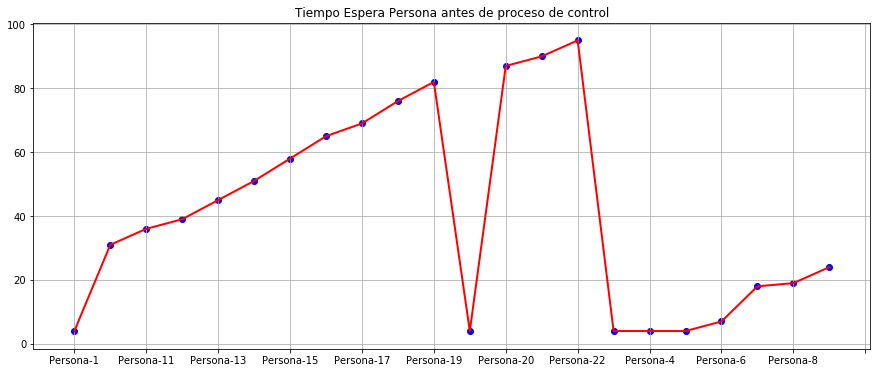

In [83]:
# Generamos la grafica del tiempo de espera
datos=sorted(tiempo_espera.items()) # Ordenamos los datos
x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
pp.figure(figsize=(15,6))
pp.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
pp.plot(x,y,linewidth=2,color='red') #Dibujamos las lineas
pp.scatter(x,y,color='blue') # Dibujamos los puntos (x,y)
pp.title("Tiempo Espera Persona antes de proceso de control")
pp.grid(True) #Generamos una cuadricula
pp.show() #Mostramos el grafico

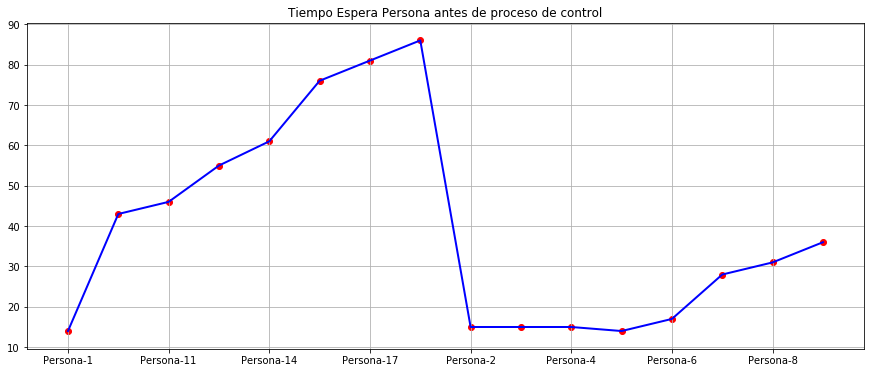

In [86]:
# Generamos la grafica del total vacunacion
datos=sorted(tiempo_total_vacunacion.items()) # Ordenamos los datos
x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
pp.figure(figsize=(15,6))
pp.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
pp.plot(x,y,linewidth=2,color='blue') #Dibujamos las lineas
pp.scatter(x,y,color='red') # Dibujamos los puntos (x,y)
pp.title("Tiempo Espera Persona antes de proceso de control")
pp.grid(True) #Generamos una cuadricula
pp.show() #Mostramos el grafico

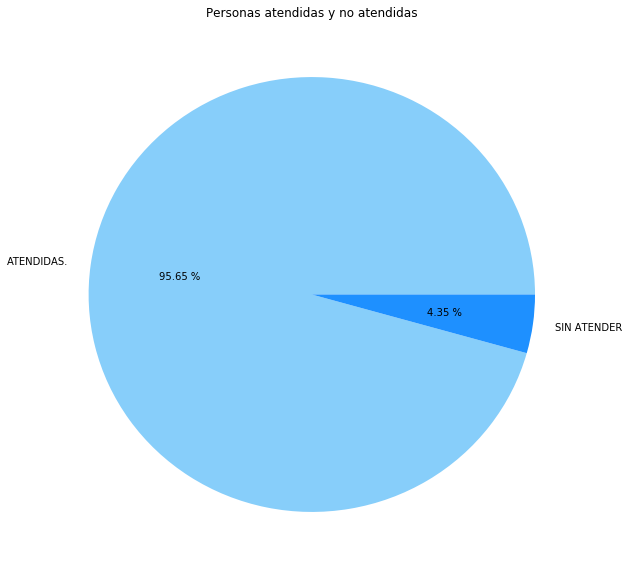

In [85]:
# Generamos la grafica de pacientes que se atendieron y los que se quedaron sin atender
pp.figure(figsize=(10,10))
etiquetas = ['ATENDIDAS.', 'SIN ATENDER']
colores = ['lightskyblue', 'dodgerblue']
pp.pie([personas_atendidas, personas_no_atendidas], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Personas atendidas y no atendidas')
pp.show()